[View in Colaboratory](https://colab.research.google.com/github/rdenadai/dsp_study_notebooks/blob/master/notebooks/dsp101d.ipynb)

## DSP 101d

Experiments on Digital Signal Processing, ranging from random generated signals, voice and images!

In these experiments, we are not analysing signals in the range of DSP but also with an statistical view...

To build this document we use a lot of resources, here are some of the most important.
- References:
 - [DSP Guide](http://www.dspguide.com)
 - [Understand the Fourier transform and its applications](https://www.udemy.com/fourier-transform-mxc/)
 - [Elegant SciPy](https://github.com/elegant-scipy/elegant-scipy)
 - [DSP Tutorial](https://www.tutorialspoint.com/digital_signal_processing/index.htm)
 - [Plotly FFT Filters](https://plot.ly/python/fft-filters/)
 - [Digital Signal Processing {youtube}](https://www.youtube.com/playlist?list=PLuh62Q4Sv7BUSzx5Jr8Wrxxn-U10qG1et)
 - [Signal Processing 101 {youtube}](https://www.youtube.com/watch?v=KZd68xgasIU&list=PLJ-OcUCIty7evBmHvYRv66RcuziszpSFB)
 - [All Signal Processing {youtube}](https://www.youtube.com/user/allsignalprocessing/playlists)


In [0]:
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.signal import resample
from scipy import interpolate
from scipy import signal
from scipy import fftpack
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import Audio

%matplotlib inline

def normalization(x, m=255):
    return (((x - min(x)) / (max(x) - min(x))) * m).astype('int64')

def normalization2(x, a, b):
    return (a + (((x - min(x)) * (b - a)) / (max(x) - min(x)))).astype('float64')

def sine(A=4096, f=1, t=1, Fs=1024, phi=0, dtype=np.int64):
    n = np.arange(Fs * t)
    return (A * np.sin((((2 * np.pi * f) * n) / Fs) + phi)).astype(dtype)

def cosine(A=4096, f=1, t=1, Fs=1024, phi=0, dtype=np.int64):
    n = np.arange(Fs * t)
    return (A * np.cos((((2 * np.pi * f) * n) / Fs) + phi)).astype(dtype)

def complex_wave(A=1, f=1, t=1, Fs=1024, phi=0):
    n = np.arange(Fs * t)
    return (A * np.exp((((2 * np.pi * f) * n) / Fs) * 1j + phi))

## Frequency Resolution

> *"**Frequency resolution is the distance in Hz between two adjacent data points in the DFT**. The frequency resolution of a DFT is defined as $\frac{F_s}{N}$. Where $F_s$ is the sampling rate and $N$ is the number of data points. The denominator can be expressed in terms of sampling rate and time, $N=F_st$. In other words, **the only thing that increases frequency resolution is time**. Changes in sampling rate do nothing towards increasing the frequency resolution if the actual time span of your signal is the same. By increasing the sampling rate, you're only increasing the frequency coverage. Your frequency axis will span more values, but they will be spaced the same distance in Hz as the lower sampling rate.
"* [Quora](http://qr.ae/TUI1Mf)

Frequencies X1[n]:  [3.  3.5]
Frequencies X2[n]:  [ 5.   9.8 10.2]


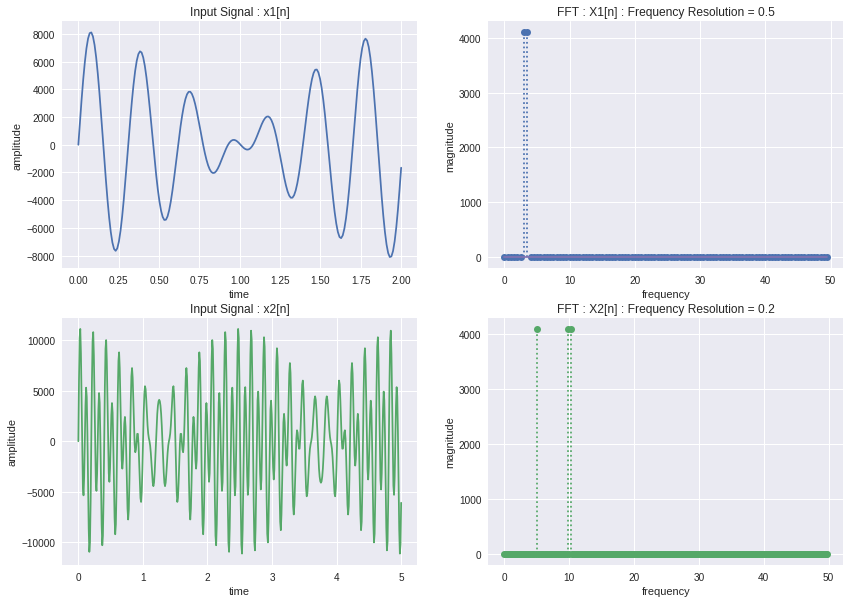

In [3]:
def frequency_resolution(x, t):
    Fs = int(x.size / t)
    X = fftpack.fft(x)
    nyquist = int(x.size / 2)
    time = np.linspace(0, t, Fs * t)
    freqs = (fftpack.fftfreq(x.size) * Fs).astype('float32')
    mag = 2 * (np.abs(X) / x.size)
    return x, mag[:nyquist], time, freqs[:nyquist]

Fs = 100

t = 2
x1 = sine(f=3, t=t, Fs=Fs, dtype=np.float32) + \
     sine(f=3.5, t=t, Fs=Fs, dtype=np.float32)
x1, X1, time1, freqs1 = frequency_resolution(x1, t)
res1 = Fs/x1.size
print('Frequencies X1[n]: ', np.where(X1 > 10)[0] * res1)

t = 5
x2 = sine(f=5, t=t, Fs=Fs, dtype=np.float32) + \
     sine(f=9.8, t=t, Fs=Fs, dtype=np.float32) + \
     sine(f=10.2, t=t, Fs=Fs, dtype=np.float32)
x2, X2, time2, freqs2 = frequency_resolution(x2, t)
res2 = Fs/x2.size
print('Frequencies X2[n]: ', np.where(X2 > 10)[0] * res2)

plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.title('Input Signal : x1[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time1, x1)
plt.subplot(222)
plt.title(f'FFT : X1[n] : Frequency Resolution = {res1}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs1, X1, linefmt='C0:')
plt.subplot(223)
plt.title('Input Signal : x2[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time2, x2, color='C1')
plt.subplot(224)
plt.title(f'FFT : X2[n] : Frequency Resolution = {res2}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs2, X2, linefmt='C1:', markerfmt='C1o', basefmt='C1')
plt.show()

### Zero-padding in Time Domain

"*Zero padding in time domain correspond to ideal interpolation in the frequency domain.*" [JOS CCRMA Stanford](https://ccrma.stanford.edu/~jos/sasp/Zero_Padding_Time_Domain.html)

"*Sometimes people will say that zero-padding in the time domain yields higher spectral resolution in the frequency domain. However, signal processing practitioners should not say that, because 'resolution' in signal processing refers to the ability to 'resolve' closely spaced features in a spectrum analysis. The usual way to increase spectral resolution is to **take a longer DFT without zero padding**...*" [JOS CCRMA Stanford](https://ccrma.stanford.edu/~jos/mdft/Zero_Padding_Applications.html)

Besides the above citation, which observes the correct way to implement better frequency resolution, the bellow example shows the use of zero padding in time domain, in a certain way to improve **frequency peak resolve**, make it possible to find lower and lower frequencies.


In [0]:
def zero_padding_time_domain(x, t=1, resolution=40):
    Fs_org = x.size
    res = int(np.ceil(resolution))
    # In this line we are actually doing the zero padding at end
    x = np.append(x, np.zeros(res))
    X = 2 * np.abs(fftpack.fft(x)) / Fs_org
    
    Fs = x.size
    time = np.linspace(0, t, Fs)
    freqs = (fftpack.fftfreq(x.size) * Fs_org / t).astype('float32')
    nyquist = int(len(freqs) / 5)
    return x, X[:nyquist], time, freqs[:nyquist]

def find_frequecies(X, resolution):
    return np.where(X > np.max(X) - np.mean(X))[0] * resolution

Frequencies X1[n]:  [0.]
Frequencies X2[n]:  [0.         0.16666667 0.33333333]


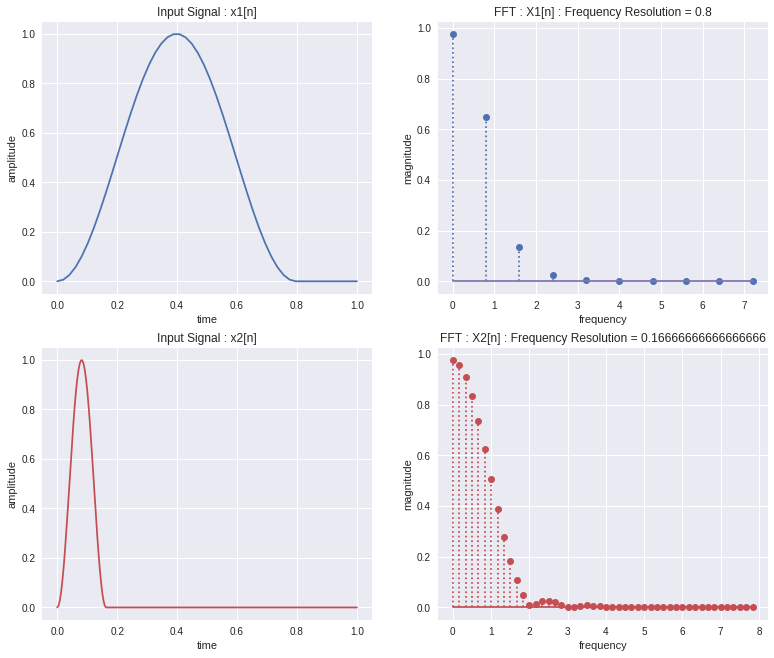

In [5]:
Fs = 40
x1 = np.hanning(Fs)
x1, X1, time1, freqs1 = zero_padding_time_domain(x1, 1, 10)

x2 = np.hanning(Fs)
x2, X2, time2, freqs2 = zero_padding_time_domain(x2, 1, Fs * 5)

res1 = Fs/x1.size
res2 = Fs/x2.size
print('Frequencies X1[n]: ', find_frequecies(X1, res1))
print('Frequencies X2[n]: ', find_frequecies(X2, res2))

plt.figure(figsize=(13, 11))
plt.subplot(221)
plt.title('Input Signal : x1[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time1, x1)
plt.subplot(222)
plt.title(f'FFT : X1[n] : Frequency Resolution = {Fs/x1.size}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs1, X1, linefmt='C0:')
plt.subplot(223)
plt.title('Input Signal : x2[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time2, x2, color='C2')
plt.subplot(224)
plt.title(f'FFT : X2[n] : Frequency Resolution = {Fs/x2.size}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs2, X2, linefmt='C2:', markerfmt='C2o', basefmt='C2')
plt.show()

Frequencies X1[n]:  [3.25 9.75]
Frequencies X2[n]:  [ 5.         15.66666667]


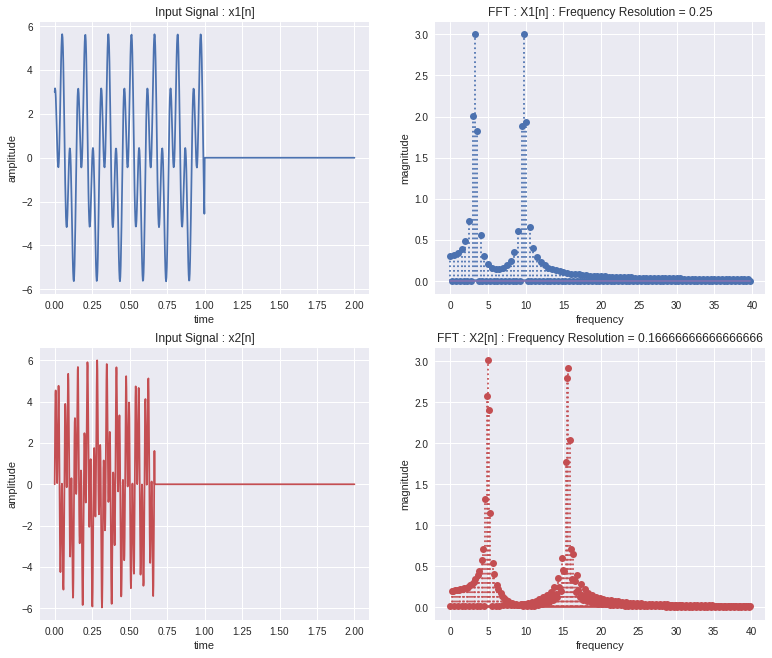

In [6]:
t = 2
Fs = 200
x1 = sine(A=3, f=3.25, t=t, Fs=Fs, dtype=np.float32) + \
     cosine(A=3, f=9.75, t=t, Fs=Fs, dtype=np.float32)
x1, X1, time1, freqs1 = zero_padding_time_domain(x1, t, Fs * 2)

x2 = sine(A=3, f=5, t=t, Fs=Fs, dtype=np.float32) + \
     sine(A=3, f=15.6, t=t, Fs=Fs, dtype=np.float32)
x2, X2, time2, freqs2 = zero_padding_time_domain(x2, t, Fs * 4)

res1 = Fs/x1.size
res2 = Fs/x2.size
print('Frequencies X1[n]: ', find_frequecies(X1, res1))
print('Frequencies X2[n]: ', find_frequecies(X2, res2))

plt.figure(figsize=(13, 11))
plt.subplot(221)
plt.title('Input Signal : x1[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time1, x1)
plt.subplot(222)
plt.title(f'FFT : X1[n] : Frequency Resolution = {Fs/x1.size}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs1, X1, linefmt='C0:')
plt.subplot(223)
plt.title('Input Signal : x2[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time2, x2, color='C2')
plt.subplot(224)
plt.title(f'FFT : X2[n] : Frequency Resolution = {Fs/x2.size}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs2, X2, linefmt='C2:', markerfmt='C2o', basefmt='C2')
plt.show()

### Zero-padding in Frequency Domain

The same thing the was accomplished above, doing zero-padding in time domain, can be inversed done in frequency doman.

This interpolation of newer points add to the frequency must be done in the middle of the spectrum... this means that we are adding the zero padding right in the middle of the frequency spectrum.

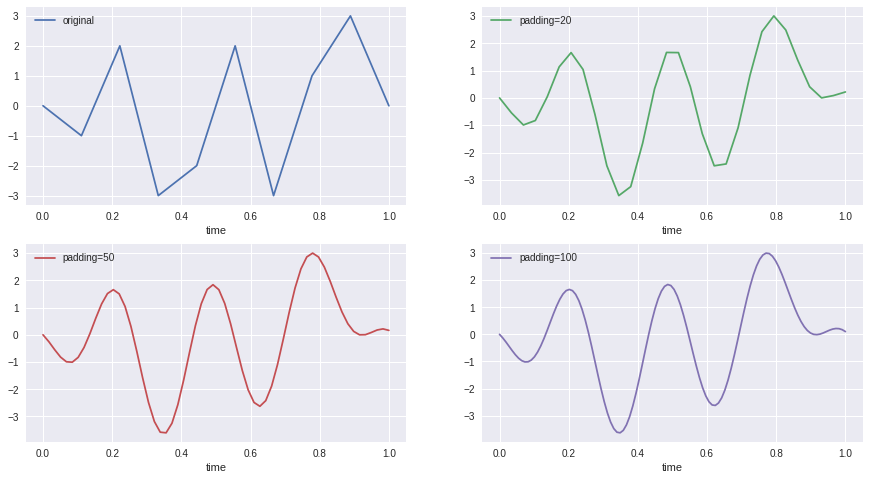

In [7]:
def zero_padding_frequency_domain(x, padding=10):
    l = int(np.floor(x.size / 2))
    X = fftpack.fft(x)
    Xa = np.append(X[:l], np.zeros(padding))
    Xa = np.append(Xa, X[l:])
    xn = fftpack.ifft(Xa).real
    norm = np.max(x) / np.max(xn)
    return np.linspace(0, 1, xn.size), xn * norm

x = np.array([0, -1, 2, -3, -2, 2, -3, 1, 3, 0])
s = x.size

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, 1, s), x, label='original')
plt.xlabel('time')
plt.legend()
for i, z in enumerate([s*2, s*5, s*10]):
    time, signal = zero_padding_frequency_domain(x, z)
    plt.subplot(2, 2, i+2)
    plt.plot(time, signal, label=f'padding={z}', color=f'C{i+1}')
    plt.xlabel('time')
    plt.legend()
plt.show()

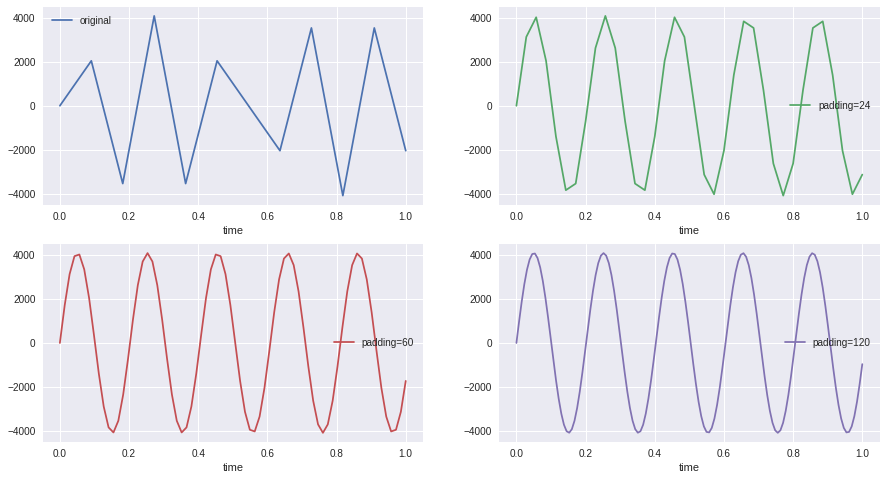

In [8]:
x = sine(f=5, t=1, Fs=12, dtype=np.float32)
s = x.size

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, 1, s), x, label='original')
plt.xlabel('time')
plt.legend()
for i, z in enumerate([s*2, s*5, s*10]):
    time, signal = zero_padding_frequency_domain(x, z)
    plt.subplot(2, 2, i+2)
    plt.plot(time, signal, label=f'padding={z}', color=f'C{i+1}')
    plt.xlabel('time')
    plt.legend()
plt.show()

Just for comparison, bellow we show how the interpolation can almost recreate the same signal as one capture with great sampling rate.

Is normal and x padded equals:  True


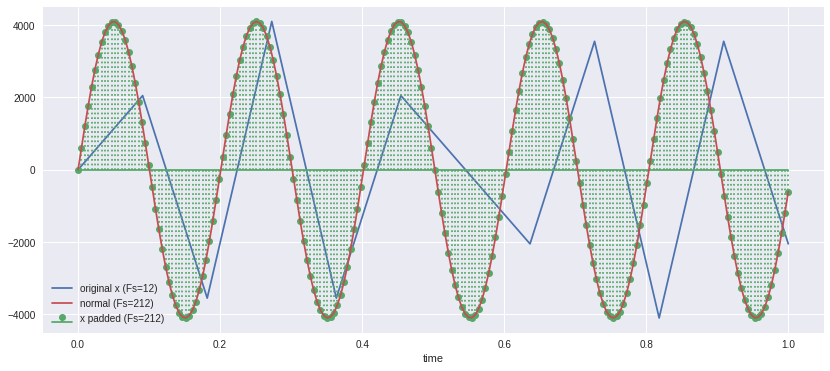

In [302]:
x = sine(f=5, t=1, Fs=12, dtype=np.float32)
time, padded = zero_padding_frequency_domain(x, 200)
normal = sine(f=5, t=1, Fs=212, dtype=np.float32)

print('Is normal and x padded equals: ', sum(m-padded) < 1E-10)

plt.figure(figsize=(14, 6))
plt.plot(np.linspace(0, 1, 12), x, label='original x (Fs=12)')
plt.stem(time, signal, label='x padded (Fs=212)', linefmt='C1:', markerfmt='C1o', basefmt='C1')
plt.plot(time, m, label='normal (Fs=212)', color='C2')
plt.legend()
plt.xlabel('time')
plt.show()

### Aliasing

*"Aliasing is an effect that causes different signals to become indistinguishable when sampled. It also refers to the distortion or artifact that results when the signal reconstructed from samples is different from the original continuous signal."* [wiki](https://en.wikipedia.org/wiki/Aliasing)

To avoid aliasing when sampling a signal (specially in continuous time) is to apply the **Nyquist-Shannon sampling theorem**, that states:

Any signal should be sampled at least 2x it's bandlimited frequency. [wiki](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)

> *A sufficient sample-rate is therefore $2B$ samples/second, or anything larger. Equivalently, for a given sample rate $F_s$, perfect reconstruction is guaranteed possible for a bandlimit $B < \frac{F_s}{2}$.*

This means that $F_s > 2 \times B$. 

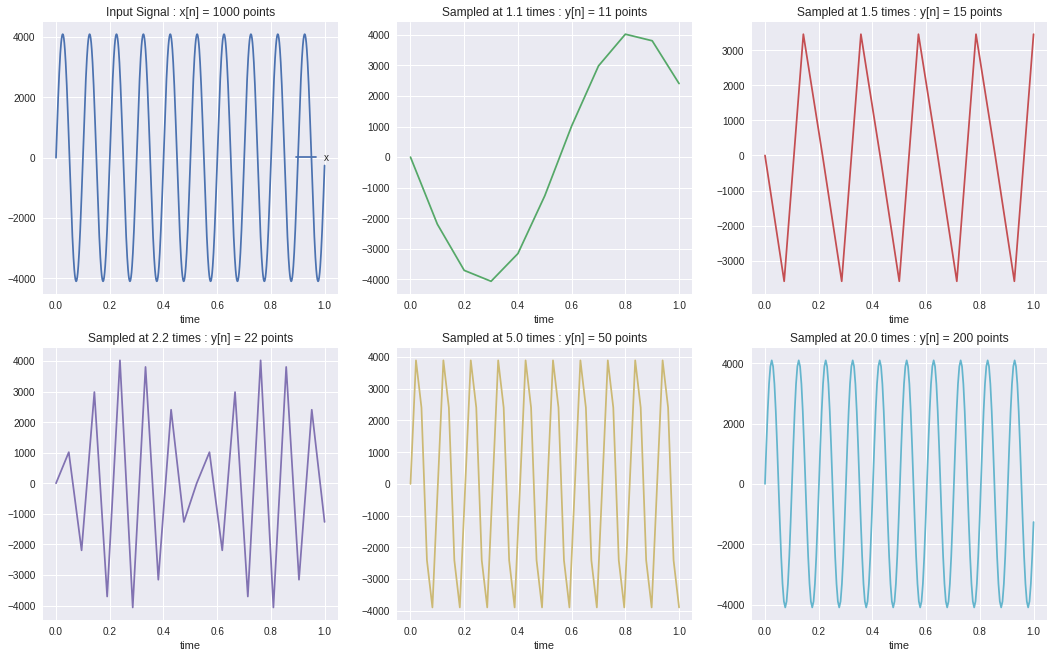

In [286]:
f = 10
t = 1
Fs = 1000
time = np.linspace(0, t, Fs * t, dtype=np.float32)
x = sine(f=f, t=t, Fs=Fs)

plt.figure(figsize=(18, 11))
plt.subplot(2, 3, 1)
plt.plot(time, x, label='x')
plt.title(f'Input Signal : x[n] = {x.size} points')
plt.xlabel('time')
plt.legend()
srates = [11, 15, 22, 50, 200]
for i, rt in enumerate(srates):
    idx = np.ceil(np.arange(0, Fs, Fs/rt)).astype('int32')
    y = x[idx]
    time_y = np.linspace(0, t, y.size, dtype=np.float32)
    plt.subplot(2, 3, i+2)
    plt.title(f'Sampled at {rt/10} times : y[n] = {y.size} points')
    plt.plot(time_y, y, color=f'C{i+1}')
    plt.xlabel('time')
plt.show()